## Feature Engineering in RAM-Limited Data, Part 5

#### CV for mean encoding of `target_combine`

#### CV@2015-12-28:
- benchmark: val = 1.62857
- with only `ind_actividad_client_combine`, `tiprel_1mes_combine`, `target_combine`, mlogloss=1.57141
- with `ind_actividad_client_combine`, `tiprel_1mes_combine`, `target_combine`, `n_products` and patterns: val = 1.31122
    - Private score: 0.0302475, public score: 0.0299266

- with all above and mean encoding of target indicator and target #products: mlogloss=1.30756
    - Private score: 0.0302597, public score: 0.0299519

In [1]:
from santander_helper import *
%matplotlib inline

Generate data

In [2]:
x_train, y_train = create_train_test('2015-06-28', target_flag=True, pattern_flag=True)

Loading 2015-05-28 data
Loading 2015-06-28 data
Products in 2015-06-28
Products in 2015-05-28
New products added in 2015-06-28
Join customer features and previous month products for 2015-06-28
Concatenate this and previous months ind_activadad_cliente
Concatenate this and previous months tiprel_1mes
Combine all products for each customer

Start counting patterns:
Encoding pattern...


100%|████████████████████████████████████████████████████████████████████████| 640825/640825 [01:42<00:00, 6249.66it/s]


Finding pattern...
Counting pattern...


100%|████████████████████████████████████████████████████████████████████████| 634760/634760 [03:13<00:00, 3286.08it/s]


Prepare target
Time used: 6.167 min


In [3]:
x_val, y_val = create_train_test('2015-12-28', max_lag=5, target_flag=True, pattern_flag=True)

Loading 2015-11-28 data
Loading 2015-12-28 data
Products in 2015-12-28
Products in 2015-11-28
New products added in 2015-12-28
Join customer features and previous month products for 2015-12-28
Concatenate this and previous months ind_activadad_cliente
Concatenate this and previous months tiprel_1mes
Combine all products for each customer

Start counting patterns:
Encoding pattern...


100%|████████████████████████████████████████████████████████████████████████| 912728/912728 [02:22<00:00, 6398.12it/s]


Finding pattern...
Counting pattern...


100%|████████████████████████████████████████████████████████████████████████| 893990/893990 [04:29<00:00, 3318.78it/s]


Prepare target
Time used: 8.612 min


In [4]:
x_test = create_train_test('2016-06-28', max_lag=5, target_flag=False, pattern_flag=True)

Loading 2016-05-28 data
Loading 2016-06-28 data
Products in 2016-06-28
Products in 2016-05-28
New products added in 2016-06-28
Join customer features and previous month products for 2016-06-28
Concatenate this and previous months ind_activadad_cliente
Concatenate this and previous months tiprel_1mes
Combine all products for each customer

Start counting patterns:
Encoding pattern...


100%|████████████████████████████████████████████████████████████████████████| 938423/938423 [02:28<00:00, 6321.45it/s]


Finding pattern...
Counting pattern...


100%|████████████████████████████████████████████████████████████████████████| 930436/930436 [04:41<00:00, 3300.62it/s]


Time used: 7.568 min


## Train model

- benchmark: val = 1.62857
- with only `ind_actividad_client_combine`, `tiprel_1mes_combine`, `target_combine`, mlogloss=1.57141
- with `ind_actividad_client_combine`, `tiprel_1mes_combine`, `target_combine`, `n_products` and patterns: val = 1.31122
- with all above and mean encoding of target indicator and target #products: mlogloss=1.30756
- with all above and mean encoding of each product: mlogloss=1.29115

In [11]:
param = {'objective': 'multi:softprob', 
         'eta': 0.05, 
         'max_depth': 8, 
         'silent': 1, 
         'num_class': len(target_cols),
         'eval_metric': 'mlogloss',
         'min_child_weight': 1,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'seed': 0}
num_rounds = 120

dtrain = xgb.DMatrix(x_train.values, y_train.values)
dval = xgb.DMatrix(x_val.values, y_val.values)

train_history = {}
np.random.seed(0)
for n in range(10):
    train_history[n] = {}
    param['seed'] = np.random.randint(10**6)
    model = xgb.train(param, dtrain, num_rounds, evals=[(dtrain, 'train'), (dval, 'val')], 
        verbose_eval=True, evals_result=train_history[n])

[0]	train-mlogloss:2.70903	val-mlogloss:2.73873
[1]	train-mlogloss:2.53678	val-mlogloss:2.59098
[2]	train-mlogloss:2.40034	val-mlogloss:2.46699
[3]	train-mlogloss:2.28557	val-mlogloss:2.36497
[4]	train-mlogloss:2.18614	val-mlogloss:2.27827
[5]	train-mlogloss:2.09942	val-mlogloss:2.20174
[6]	train-mlogloss:2.02198	val-mlogloss:2.13291
[7]	train-mlogloss:1.95192	val-mlogloss:2.07303
[8]	train-mlogloss:1.88901	val-mlogloss:2.01858
[9]	train-mlogloss:1.83189	val-mlogloss:1.96977
[10]	train-mlogloss:1.77926	val-mlogloss:1.92354
[11]	train-mlogloss:1.73043	val-mlogloss:1.88093
[12]	train-mlogloss:1.68511	val-mlogloss:1.84279
[13]	train-mlogloss:1.64311	val-mlogloss:1.8066
[14]	train-mlogloss:1.60385	val-mlogloss:1.77342
[15]	train-mlogloss:1.56708	val-mlogloss:1.74457
[16]	train-mlogloss:1.53271	val-mlogloss:1.7145
[17]	train-mlogloss:1.50018	val-mlogloss:1.68711
[18]	train-mlogloss:1.46977	val-mlogloss:1.66147
[19]	train-mlogloss:1.4415	val-mlogloss:1.6371
[20]	train-mlogloss:1.41427	val-ml

[47]	train-mlogloss:1.01553	val-mlogloss:1.30178
[48]	train-mlogloss:1.00791	val-mlogloss:1.2952
[49]	train-mlogloss:1.00061	val-mlogloss:1.29006
[50]	train-mlogloss:0.993419	val-mlogloss:1.28477
[51]	train-mlogloss:0.986504	val-mlogloss:1.2796
[52]	train-mlogloss:0.979822	val-mlogloss:1.27468
[53]	train-mlogloss:0.973301	val-mlogloss:1.26956
[54]	train-mlogloss:0.966878	val-mlogloss:1.26476
[55]	train-mlogloss:0.960928	val-mlogloss:1.26095
[56]	train-mlogloss:0.955069	val-mlogloss:1.25738
[57]	train-mlogloss:0.949447	val-mlogloss:1.25368
[58]	train-mlogloss:0.943923	val-mlogloss:1.24928
[59]	train-mlogloss:0.938519	val-mlogloss:1.24521
[60]	train-mlogloss:0.933382	val-mlogloss:1.24124
[61]	train-mlogloss:0.92848	val-mlogloss:1.23766
[62]	train-mlogloss:0.923568	val-mlogloss:1.23393
[63]	train-mlogloss:0.918872	val-mlogloss:1.23063
[64]	train-mlogloss:0.914347	val-mlogloss:1.2275
[65]	train-mlogloss:0.90998	val-mlogloss:1.22416
[66]	train-mlogloss:0.905757	val-mlogloss:1.22161
[67]	tra

[93]	train-mlogloss:0.824573	val-mlogloss:1.16867
[94]	train-mlogloss:0.822447	val-mlogloss:1.16754
[95]	train-mlogloss:0.82027	val-mlogloss:1.16648
[96]	train-mlogloss:0.818053	val-mlogloss:1.16515
[97]	train-mlogloss:0.816114	val-mlogloss:1.16433
[98]	train-mlogloss:0.814095	val-mlogloss:1.16362
[99]	train-mlogloss:0.812181	val-mlogloss:1.1626
[100]	train-mlogloss:0.81038	val-mlogloss:1.16153
[101]	train-mlogloss:0.808503	val-mlogloss:1.16062
[102]	train-mlogloss:0.806586	val-mlogloss:1.15979
[103]	train-mlogloss:0.804689	val-mlogloss:1.15928
[104]	train-mlogloss:0.80286	val-mlogloss:1.15847
[105]	train-mlogloss:0.800998	val-mlogloss:1.1578
[106]	train-mlogloss:0.799328	val-mlogloss:1.1569
[107]	train-mlogloss:0.797707	val-mlogloss:1.15614
[108]	train-mlogloss:0.796027	val-mlogloss:1.15534
[109]	train-mlogloss:0.79438	val-mlogloss:1.15474
[110]	train-mlogloss:0.792708	val-mlogloss:1.15412
[111]	train-mlogloss:0.791001	val-mlogloss:1.15336
[112]	train-mlogloss:0.789349	val-mlogloss:1.

[19]	train-mlogloss:1.442	val-mlogloss:1.63388
[20]	train-mlogloss:1.41485	val-mlogloss:1.61031
[21]	train-mlogloss:1.389	val-mlogloss:1.58781
[22]	train-mlogloss:1.36459	val-mlogloss:1.56978
[23]	train-mlogloss:1.34153	val-mlogloss:1.55031
[24]	train-mlogloss:1.31953	val-mlogloss:1.533
[25]	train-mlogloss:1.29883	val-mlogloss:1.51545
[26]	train-mlogloss:1.27881	val-mlogloss:1.4997
[27]	train-mlogloss:1.25969	val-mlogloss:1.48324
[28]	train-mlogloss:1.2419	val-mlogloss:1.4689
[29]	train-mlogloss:1.2246	val-mlogloss:1.4542
[30]	train-mlogloss:1.20843	val-mlogloss:1.4407
[31]	train-mlogloss:1.19266	val-mlogloss:1.42752
[32]	train-mlogloss:1.17763	val-mlogloss:1.41633
[33]	train-mlogloss:1.16341	val-mlogloss:1.40455
[34]	train-mlogloss:1.14975	val-mlogloss:1.39329
[35]	train-mlogloss:1.13644	val-mlogloss:1.38272
[36]	train-mlogloss:1.12376	val-mlogloss:1.37297
[37]	train-mlogloss:1.11179	val-mlogloss:1.36341
[38]	train-mlogloss:1.10014	val-mlogloss:1.35411
[39]	train-mlogloss:1.0892	val-m

[66]	train-mlogloss:0.905781	val-mlogloss:1.22447
[67]	train-mlogloss:0.901656	val-mlogloss:1.2218
[68]	train-mlogloss:0.897616	val-mlogloss:1.21892
[69]	train-mlogloss:0.893733	val-mlogloss:1.21686
[70]	train-mlogloss:0.889898	val-mlogloss:1.21372
[71]	train-mlogloss:0.88606	val-mlogloss:1.21117
[72]	train-mlogloss:0.88239	val-mlogloss:1.20915
[73]	train-mlogloss:0.878822	val-mlogloss:1.20665
[74]	train-mlogloss:0.875432	val-mlogloss:1.20419
[75]	train-mlogloss:0.872181	val-mlogloss:1.20201
[76]	train-mlogloss:0.868943	val-mlogloss:1.20003
[77]	train-mlogloss:0.865786	val-mlogloss:1.19758
[78]	train-mlogloss:0.862805	val-mlogloss:1.19521
[79]	train-mlogloss:0.859778	val-mlogloss:1.19306
[80]	train-mlogloss:0.856934	val-mlogloss:1.19114
[81]	train-mlogloss:0.854072	val-mlogloss:1.18956
[82]	train-mlogloss:0.851156	val-mlogloss:1.18786
[83]	train-mlogloss:0.848426	val-mlogloss:1.18591
[84]	train-mlogloss:0.845659	val-mlogloss:1.18423
[85]	train-mlogloss:0.843076	val-mlogloss:1.18262
[86

[111]	train-mlogloss:0.791283	val-mlogloss:1.15474
[112]	train-mlogloss:0.789718	val-mlogloss:1.15409
[113]	train-mlogloss:0.788204	val-mlogloss:1.15369
[114]	train-mlogloss:0.786669	val-mlogloss:1.1532
[115]	train-mlogloss:0.785237	val-mlogloss:1.15273
[116]	train-mlogloss:0.78378	val-mlogloss:1.15252
[117]	train-mlogloss:0.782324	val-mlogloss:1.15221
[118]	train-mlogloss:0.780832	val-mlogloss:1.15169
[119]	train-mlogloss:0.779305	val-mlogloss:1.15147
[0]	train-mlogloss:2.7084	val-mlogloss:2.73852
[1]	train-mlogloss:2.5353	val-mlogloss:2.58312
[2]	train-mlogloss:2.39832	val-mlogloss:2.46542
[3]	train-mlogloss:2.28348	val-mlogloss:2.36825
[4]	train-mlogloss:2.18423	val-mlogloss:2.2809
[5]	train-mlogloss:2.09749	val-mlogloss:2.20285
[6]	train-mlogloss:2.02045	val-mlogloss:2.13501
[7]	train-mlogloss:1.95103	val-mlogloss:2.07206
[8]	train-mlogloss:1.88885	val-mlogloss:2.01627
[9]	train-mlogloss:1.83159	val-mlogloss:1.96581
[10]	train-mlogloss:1.77842	val-mlogloss:1.91902
[11]	train-mloglo

[38]	train-mlogloss:1.10111	val-mlogloss:1.36673
[39]	train-mlogloss:1.09033	val-mlogloss:1.35798
[40]	train-mlogloss:1.07975	val-mlogloss:1.34941
[41]	train-mlogloss:1.06955	val-mlogloss:1.34152
[42]	train-mlogloss:1.06004	val-mlogloss:1.33435
[43]	train-mlogloss:1.05069	val-mlogloss:1.32682
[44]	train-mlogloss:1.04163	val-mlogloss:1.32021
[45]	train-mlogloss:1.03301	val-mlogloss:1.31323
[46]	train-mlogloss:1.02469	val-mlogloss:1.30794
[47]	train-mlogloss:1.01647	val-mlogloss:1.30141
[48]	train-mlogloss:1.00867	val-mlogloss:1.29527
[49]	train-mlogloss:1.00125	val-mlogloss:1.28944
[50]	train-mlogloss:0.994201	val-mlogloss:1.28429
[51]	train-mlogloss:0.987249	val-mlogloss:1.27874
[52]	train-mlogloss:0.980447	val-mlogloss:1.27363
[53]	train-mlogloss:0.974015	val-mlogloss:1.26859
[54]	train-mlogloss:0.96778	val-mlogloss:1.26381
[55]	train-mlogloss:0.961798	val-mlogloss:1.25916
[56]	train-mlogloss:0.955987	val-mlogloss:1.25568
[57]	train-mlogloss:0.950336	val-mlogloss:1.2513
[58]	train-mlo

[84]	train-mlogloss:0.84621	val-mlogloss:1.18063
[85]	train-mlogloss:0.843565	val-mlogloss:1.17925
[86]	train-mlogloss:0.841146	val-mlogloss:1.17806
[87]	train-mlogloss:0.838678	val-mlogloss:1.17666
[88]	train-mlogloss:0.836125	val-mlogloss:1.17516
[89]	train-mlogloss:0.833676	val-mlogloss:1.17378
[90]	train-mlogloss:0.83134	val-mlogloss:1.17276
[91]	train-mlogloss:0.829015	val-mlogloss:1.17149
[92]	train-mlogloss:0.826689	val-mlogloss:1.17036
[93]	train-mlogloss:0.824563	val-mlogloss:1.16919
[94]	train-mlogloss:0.822342	val-mlogloss:1.16871
[95]	train-mlogloss:0.820147	val-mlogloss:1.16776
[96]	train-mlogloss:0.818036	val-mlogloss:1.16682
[97]	train-mlogloss:0.815858	val-mlogloss:1.16602
[98]	train-mlogloss:0.81389	val-mlogloss:1.16508
[99]	train-mlogloss:0.811975	val-mlogloss:1.16437
[100]	train-mlogloss:0.810105	val-mlogloss:1.16353
[101]	train-mlogloss:0.808093	val-mlogloss:1.16297
[102]	train-mlogloss:0.806286	val-mlogloss:1.16212
[103]	train-mlogloss:0.80439	val-mlogloss:1.16135


In [55]:
result = {(k, d): train_history[k][d]['mlogloss'] for k in range(10) for d in ['train', 'val']}
result = pd.DataFrame(result)

result_mean = result.groupby(level=1, axis=1).mean()
result_std = result.groupby(level=1, axis=1).std()

result = pd.concat((result_mean, result_std), axis=1, ignore_index=True)
result.columns = pd.MultiIndex.from_product([['mean', 'std'], ['train', 'val']], names=['quantity', 'data'])

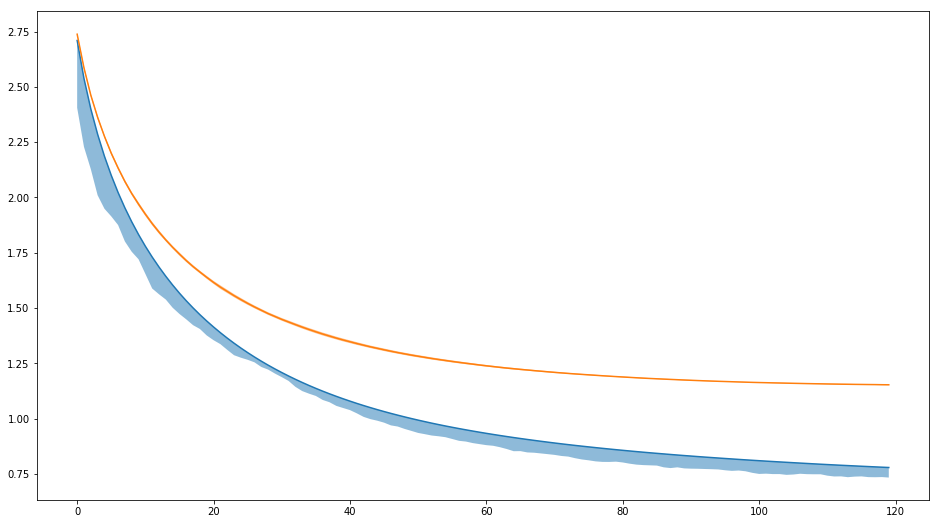

In [62]:
plt.figure(figsize=(16, 9))
plt.plot(result.loc[:, ('mean', slice(None))])
plt.fill_between(result.index, result.loc[:, ('mean', 'train')]-result.loc[:, ('std', 'train')], 
    result.loc[:, ('mean', 'train')]+result.loc[:, ('std', 'train')], alpha=0.5)
plt.fill_between(result.index, result.loc[:, ('mean', 'val')]-result.loc[:, ('std', 'val')], 
    result.loc[:, ('mean', 'val')]+result.loc[:, ('std', 'val')], alpha=0.5)
plt.g

Prediction from my model

In [6]:
preds = model.predict(xgb.DMatrix(x_test.values))

df_preds = pd.DataFrame(preds, index=x_test.index, columns=target_cols)
# Remove already bought products 
df_preds[x_test[target_cols]==1] = 0 
preds = df_preds.values
preds = np.argsort(preds, axis=1)
preds = np.fliplr(preds)[:, :7]

Write out prediction results from my model

In [7]:
test_id = x_test.loc[:, 'ncodpers'].values
final_preds = [' '.join([target_cols[k] for k in pred]) for pred in preds]

out_df = pd.DataFrame({'ncodpers': test_id, 'added_products': final_preds})
out_df.to_csv('eda_4_19.csv.gz', compression='gzip', index=False)

In [8]:
#pd.Series(x_train.columns).to_csv('x_train_cols.csv')